In [ ]:
import pandas as pd
from sklearn import preprocessing, neighbors
from scipy.spatial import distance
import numpy as np
import  matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, laplacian_kernel
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy.linalg import sqrtm, inv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Payment Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud analytics/Payments.csv")

In [ ]:
data

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396
...,...,...,...
130530,1344,1390,21739
130531,1914,1390,3374
130532,1914,1390,5186
130533,1914,1390,1559


In [ ]:
import networkx as nx

# Sum the Amounts for each Sender-Receiver pair
aggregated_payments_df = data.groupby(['Sender', 'Receiver']).sum().reset_index()

# Create a directed graph from the aggregated DataFrame
G = nx.Graph()
for index, row in aggregated_payments_df.iterrows():
    G.add_edge(row['Sender'], row['Receiver'], weight=row['Amount'])

# Generate adjacency matrix from the graph
adjacency_matrix = nx.adjacency_matrix(G)

# Converting to a more readable format (DataFrame) for display
adjacency_df = pd.DataFrame(adjacency_matrix.todense(), index=G.nodes(), columns=G.nodes())
adjacency_df

,1001,1037,1136,1246,1358,1002,1003,1008,1023,1034,...,2170,2171,2172,2174,2177,2182,2184,2188,2189,2190
1001,0,3786658,162378,953873,2395,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1037,3786658,0,1055540,1445997,0,57581,0,0,343875,0,...,0,0,0,0,0,0,0,0,0,0
1136,162378,1055540,0,0,0,0,0,3017990,466065,0,...,0,0,0,0,0,0,0,540449,0,0
1246,953873,1445997,0,0,0,0,0,0,0,247740,...,0,0,0,0,0,0,3639,0,0,0
1358,2395,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2184,0,0,0,3639,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2188,0,0,540449,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


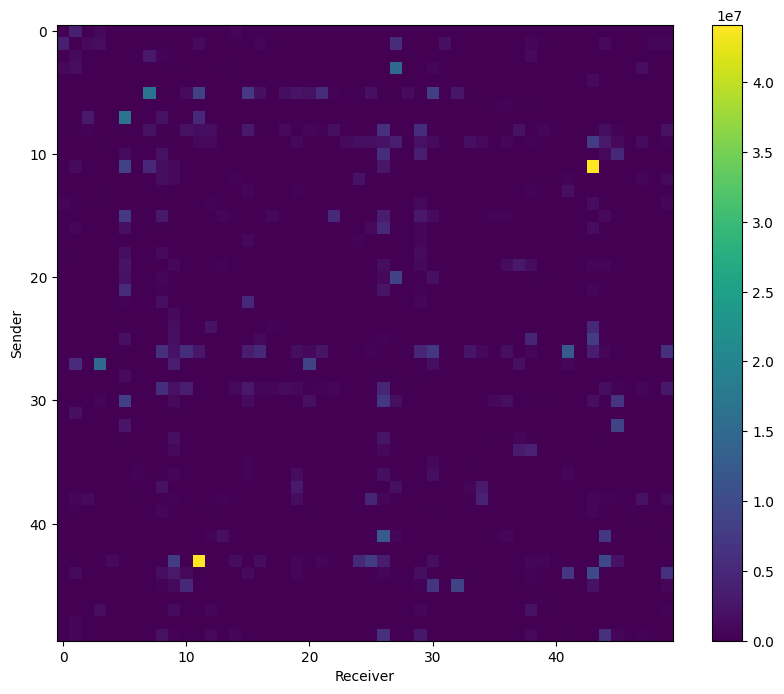

In [ ]:
import matplotlib.pyplot as plt

# Create a heatmap using Matplotlib with a black and white color scheme
plt.figure(figsize=(10, 8))
plt.imshow(adjacency_df.iloc[:50,:50], interpolation='nearest')
plt.colorbar()
# plt.title('Zoomed view of Adjacency matrix heatmap')
plt.xlabel('Receiver')
plt.ylabel('Sender')
plt.show()


In [ ]:
import torch
adjacency_matrix = nx.to_numpy_array(G)

adjacency_tensor = torch.tensor(adjacency_matrix, dtype=torch.float)

# Add self-loops to the adjacency matrix
adjacency_tensor += torch.eye(adjacency_tensor.size(0))

# Calculate the degree matrix D and its inverse square root
degree_matrix = adjacency_tensor.sum(dim=1).diag()
inv_sqrt_degree_matrix = degree_matrix.pow(-0.5)
inv_sqrt_degree_matrix[torch.isinf(inv_sqrt_degree_matrix)] = 0

# Perform the symmetric normalization of the adjacency matrix
adjacency_tensor = torch.mm(torch.mm(inv_sqrt_degree_matrix, adjacency_tensor), inv_sqrt_degree_matrix)


In [ ]:
adjacency_tensor

tensor([[5.0615e-08, 4.8169e-02, 5.6433e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8169e-02, 3.1970e-09, 9.2196e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.6433e-03, 9.2196e-03, 2.3864e-08,  ..., 5.2299e-02, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 5.2299e-02,  ..., 3.9241e-07, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.6980e-07,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7105e-08]])

In [ ]:
pip install torch_geometric

### Perform GCN for Node embeddings

In [ ]:
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


# Extract the indices of non-zero elements (edges) and their corresponding weights
src, dest = adjacency_tensor.nonzero(as_tuple=True)
weights = adjacency_tensor[src, dest]

# Convert the indices and weights to tensors of type float
edge_index = torch.stack([torch.tensor(src), torch.tensor(dest)], dim=0).long()
edge_weight = weights.float()

# Number of nodes and creating a feature matrix with ones
num_nodes = adjacency_tensor.size(0)
x = torch.ones((num_nodes, 1), dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

# Define the GCN Model
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

class Decoder(torch.nn.Module):
    def forward(self, z):
        adj = torch.mm(z, z.t())
        return adj

class GCNAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNAutoencoder, self).__init__()
        self.encoder = Encoder(in_channels, out_channels)
        self.decoder = Decoder()

    def forward(self, x, edge_index, edge_weight):
        z = self.encoder(x, edge_index, edge_weight)
        adj_hat = self.decoder(z)
        return adj_hat, z

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and optimizer
model = GCNAutoencoder(in_channels=1, out_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Ensure the adjacency matrix tensor is on the correct device and is float
adjacency_matrix_tensor = adjacency_tensor.to(device).float()

# Define the training loop
def train():
    model.train()
    optimizer.zero_grad()
    adj_hat, _ = model(data.x, data.edge_index, data.edge_attr)
    loss = F.mse_loss(adj_hat, adjacency_matrix_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(200):
    loss = train()
    if(epoch%20==0): print(f'Epoch {epoch+20}, Loss: {loss}')

# After training, get the embeddings
model.eval()
_, embeddings = model(data.x, data.edge_index, data.edge_attr)
print(embeddings)


<ipython-input-137-7dfa155f6008>:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 20, Loss: 0.35614240169525146
Epoch 40, Loss: 0.0017404388636350632
Epoch 60, Loss: 0.0002941387356258929
Epoch 80, Loss: 0.00018547521904110909
Epoch 100, Loss: 0.00016286931349895895
Epoch 120, Loss: 0.00015575405268464237
Epoch 140, Loss: 0.00015265913680195808
Epoch 160, Loss: 0.00015094071568455547
Epoch 180, Loss: 0.00014984325389377773
Epoch 200, Loss: 0.0001490804716013372
tensor([[ 1.9109e-03, -3.8117e-04,  1.0786e-03,  ..., -1.7229e-03,
          3.3164e-04, -1.6946e-03],
        [ 3.2826e-03, -3.2277e-03,  6.5336e-03,  ..., -9.0368e-04,
          9.8860e-03,  6.8036e-03],
        [ 2.8792e-03, -1.5691e-03,  2.7732e-03,  ..., -8.6525e-04,
          3.3214e-03,  1.5855e-03],
        ...,
        [ 7.0424e-04, -3.0234e-04, -1.9807e-03,  ..., -1.7334e-03,
         -4.3944e-03, -5.1372e-03],
        [ 3.2395e-03,  1.4918e-03, -1.6398e-05,  ...,  5.2406e-04,
          1.2175e-03,  5.0273e-04],
        [ 3.5118e-03,  1.1962e-03,  1.1709e-03,  ...,  8.2494e-04,
          3.527

In [ ]:
embeddings.shape

torch.Size([799, 64])

<ipython-input-139-6045f127757f>:13: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



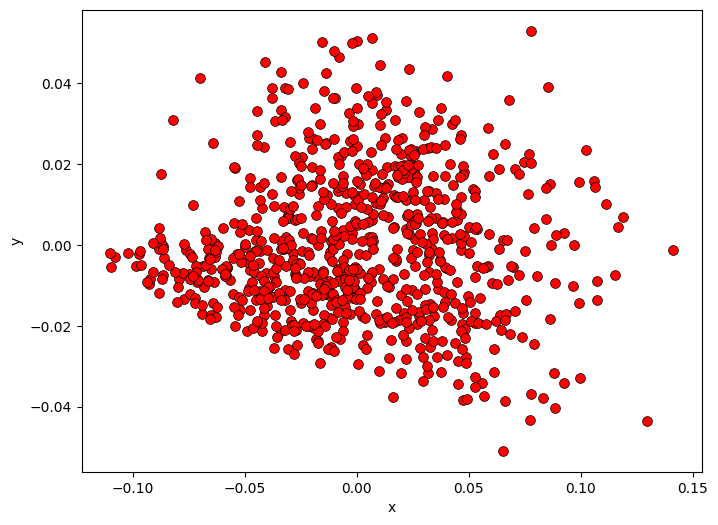

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'embeddings' is a PyTorch tensor obtained from the GCN model
embeddings_np = embeddings.cpu().detach().numpy()

# Perform PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

# Plot the 2D embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50, cmap='viridis',color='red', edgecolor='black', lw=0.5)
# plt.title('2D PCA of Node Embeddings')
plt.xlabel('x')
plt.ylabel('y')
# plt.colorbar()
plt.savefig('gcn_plot.png')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(embeddings_np)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_node_embeddings_2d(node_embeddings_2d, labels, title='Plot of Node Embeddings after Clustering', colors=None):
    """
    Plots the 2D embeddings with color coding for clusters.

    :param node_embeddings_2d: A numpy array or list of lists containing the 2D embeddings.
    :param labels: A list or array of cluster labels corresponding to each embedding.
    :param title: Title of the plot. Default is 'Plot of Node Embeddings after Clustering'.
    :param colors: A dictionary mapping cluster labels to colors. Optional.
    """
    # Default colors if none are provided
    if colors is None:
        colors = {0: 'red', 1: 'green', 2: 'orange', 3: 'blue', 4: 'purple'}

    # Create a DataFrame
    df = pd.DataFrame(node_embeddings_2d, columns=['x', 'y'])
    df['Cluster'] = labels

    # Create a plot
    plt.figure(figsize=(10, 8))

    # Plot each cluster as a separate scatter plot
    for cluster in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(
            cluster_data['x'],
            cluster_data['y'],
            c=colors.get(cluster, 'grey'),
            s=80,  # Marker size
            label=f'Cluster {cluster}',
            edgecolor='black',
            lw=0.5
        )

    # Update plot layout
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(title='Clusters', loc='upper left')

    # Show the plot
    plt.show()


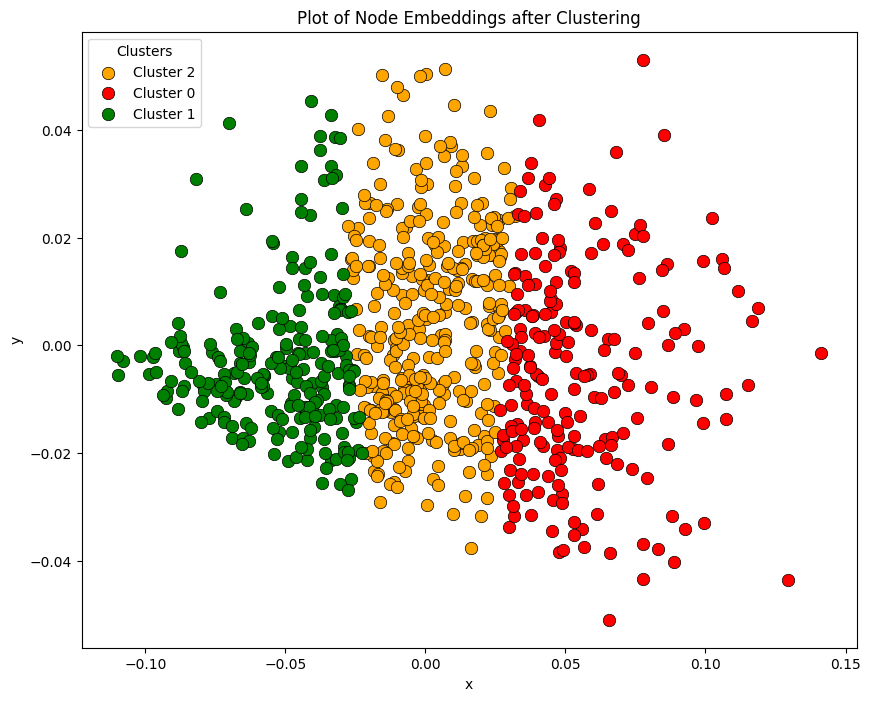

In [ ]:
pca_2d = PCA(n_components=2)
node_embeddings_2d = pca_2d.fit_transform(embeddings_np)

plot_node_embeddings_2d(node_embeddings_2d, kmeans_clusters)

### Spectral clustering

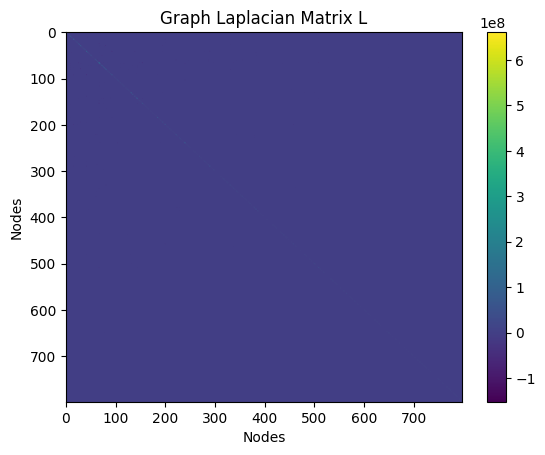

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

# Given adjacency matrix A of the undirected graph
# Replace this with your actual adjacency matrix
A = adjacency_matrix

# Ensure the adjacency matrix is symmetric
assert np.allclose(A, A.T), "The adjacency matrix must be symmetric for an undirected graph."

# Compute the degree matrix D
D = np.diag(A.sum(axis=1))

# Compute the unnormalized graph Laplacian matrix L
L = D - A
# Visualize the graph Laplacian matrix L
plt.figure()
plt.imshow(L, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Graph Laplacian Matrix L")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()



In [ ]:
def compute_normalized_laplacian(adjacency_matrix):
    # Step 1: Compute the degree matrix
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))

    # Step 2: Compute the inverse square root of the degree matrix
    # Avoid division by zero; replace zero degrees with a small value.
    degree_matrix_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(np.diag(degree_matrix), 1e-10)))

    # Step 3: Compute the normalized Laplacian matrix
    identity_matrix = np.eye(adjacency_matrix.shape[0])
    normalized_laplacian = identity_matrix - degree_matrix_inv_sqrt @ adjacency_matrix @ degree_matrix_inv_sqrt

    return normalized_laplacian

In [ ]:
L_norm = compute_normalized_laplacian(A)
L_norm

array([[ 1.        , -0.04816884, -0.00564334, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04816884,  1.        , -0.00921961, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00564334, -0.00921961,  1.        , ..., -0.05229925,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.05229925, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

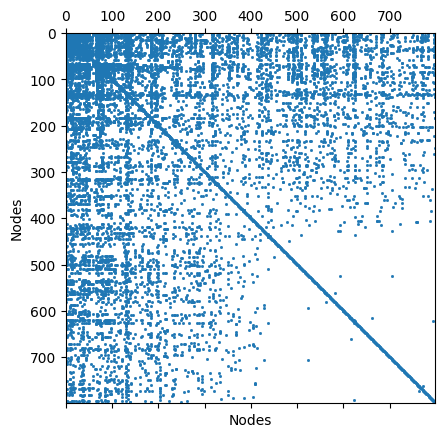

In [ ]:
plt.figure()
plt.spy(L_norm, markersize=1)
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()

In [ ]:
# Chechking whether the Laplacian matrix is hermitian.

np.all(L_norm) == np.all(L_norm.T)

True

In [ ]:
# Computing eigen values and vectors

eigen_values, eigen_vectors = eigsh(L_norm, k=16, which='SM')      # Parameter 'SM' indicated smallest magnitue of eigen values
eigen_vectors = np.round(eigen_vectors[:, np.argsort(eigen_values)], 6)
eigen_values = np.round(np.abs(eigen_values[np.argsort(eigen_values)]), 6)

In [ ]:
eigen_values

array([0.      , 0.      , 0.      , 0.002217, 0.003959, 0.015851,
       0.018062, 0.019162, 0.020535, 0.031463, 0.048221, 0.060859,
       0.076416, 0.079438, 0.082419, 0.142317])

Text(0, 0.5, 'Eigen values')

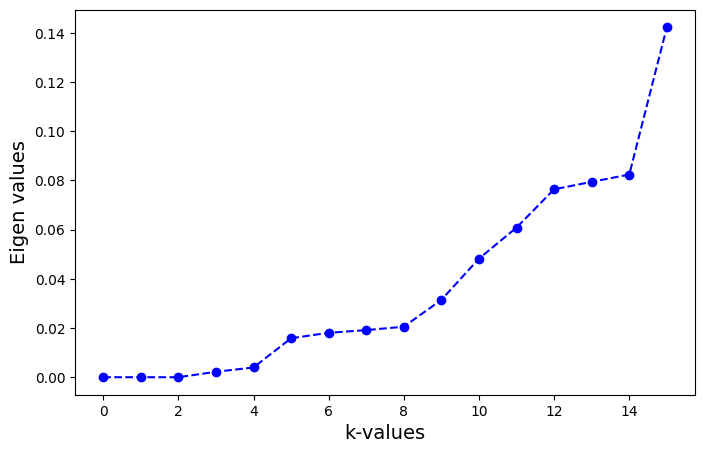

In [ ]:
# Plotting elbow points
import seaborn as sns

plt.figure(figsize=(8, 5))

plt.plot(eigen_values, color='b', marker='o', linestyle='--')
plt.xlabel('k-values', fontsize=14)
plt.ylabel('Eigen values', fontsize=14)

We can see that, eigenvalues have 3 different levels. so cluster size k=3

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def perform_spectral_clustering(L_norm, k):
    # Step 1: Compute the first k eigenvalues and eigenvectors of the normalized Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(L_norm)

    # Step 2: Extract the first k eigenvectors (sorted by increasing eigenvalues)
    U = eigenvectors[:, :k]

    # Step 3: Normalize the rows of the matrix U
    # Normalize each row to have a unit length
    row_norms = np.linalg.norm(U, axis=1)
    U_normalized = U / row_norms[:, np.newaxis]

    # Step 4: Perform K-means clustering on the rows of U_normalized
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(U_normalized)

    return cluster_labels



In [ ]:

k = 3
# Perform spectral clustering
cluster_labels = perform_spectral_clustering(L_norm, k)

# Print the cluster labels
print("Cluster labels for each node:")
print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster labels for each node:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_node_embeddings_2d(node_embeddings_2d, labels, colors=None):
    """
    Plots the 2D embeddings with color coding for clusters.

    :param node_embeddings_2d: A numpy array or list of lists containing the 2D embeddings.
    :param labels: A list or array of cluster labels corresponding to each embedding.
    :param colors: A dictionary mapping cluster labels to colors. Optional.
    """
    # Default colors if none are provided
    if colors is None:
        colors = {0: 'red', 1: 'green', 2: 'orange', 3: 'blue', 4: 'purple'}

    # Create a DataFrame
    df = pd.DataFrame(node_embeddings_2d, columns=['x', 'y'])
    df['Cluster'] = labels

    # Create a plot
    plt.figure(figsize=(8, 5))

    # Plot each cluster as a separate scatter plot
    for cluster in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(
            cluster_data['x'],
            cluster_data['y'],
            c=colors.get(cluster, 'grey'),  # Use specified color or default to grey
            s=50,  # Marker size
            edgecolors='black',  # Black edge around each point
            label=f'Cluster {cluster}',
            lw=0.4
        )

    # Update plot layout
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(title='Clusters', loc='upper left')

    # Show the plot
    plt.show()


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

scaler = StandardScaler()
normalized_A = scaler.fit_transform(A)

tsne = TSNE(n_components=2,perplexity=40, learning_rate=50, random_state=42)
tsne_result = tsne.fit_transform(normalized_A)
tsne_result.shape

(799, 2)

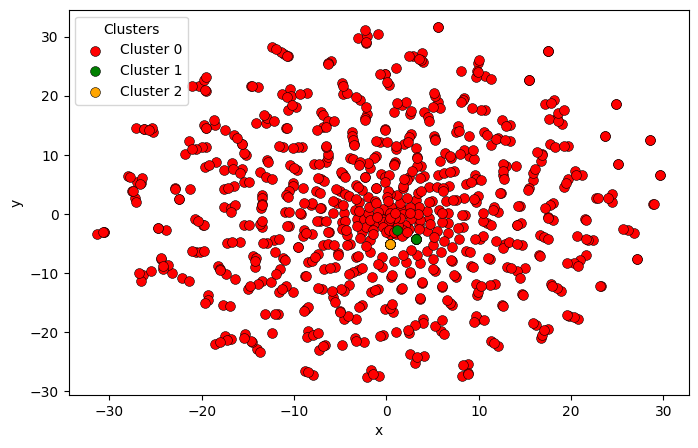

In [ ]:
plot_node_embeddings_2d(tsne_result, cluster_labels)